# Imports and Data Loading and Analysis

In [2]:
# Imports
import numpy as np
import pandas as pd
import os
import glob
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Set paths
baseDir = os.path.join(os.getcwd(),'..')
codeDir = os.path.join(baseDir, 'code')
dataDir = os.path.join(baseDir, 'data')
stimDir = os.path.join(baseDir, 'BOLD5000_Stimuli_Shared')

N_TUNING_CURVES = 8

qualtricsData = pd.read_csv(os.path.join(dataDir, "qualtricsDataClean.csv"),index_col='participant')
masterData = pd.read_csv(os.path.join(dataDir, "masterDataClean.csv"),low_memory=False,index_col='participant')
lingDirectionsAverage = pd.read_csv(os.path.join(dataDir, "lingDirectionsAverage.csv"),index_col='presentedImage')
lingDirectionsParticipant = pd.read_csv(os.path.join(dataDir, "lingDirectionsParticipant.csv"),index_col=['presentedImage','participant'])
analogDirectionsParticipant = pd.read_csv(os.path.join(dataDir, f'analogData_{N_TUNING_CURVES}_bins_Participant.csv'),index_col=['presentedImage','participant'])
analogDirectionsAverage = pd.read_csv(os.path.join(dataDir, f'analogData_{N_TUNING_CURVES}_bins_Average.csv'),index_col='presentedImage')


# Spearman Correlation between the Analog and Linguisitic Similarity Matrix

In [6]:
# Calculate the Similarity between Linguistic and Analog Data
def upper(df):
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

# Spearman Similarity Between Two Cosine Similarity Matrix
def calculateSimilarity(N_TUNING_CURVES):
    df_analog = pd.read_csv(os.path.join(dataDir, f'analogData_{N_TUNING_CURVES}_bins_Average.csv'),index_col=0)
    df_ling = pd.read_csv(os.path.join(dataDir, f'lingDirectionsAverage.csv'),index_col=0)
    
    df_analog_similarity = pd.DataFrame(cosine_similarity(df_analog),index=df_analog.index,columns=df_analog.index)
    df_ling_similarity = pd.DataFrame(cosine_similarity(df_ling),index=df_ling.index,columns=df_ling.index)

    # Now lets measure the similarity Spearman similarity
    result = stats.spearmanr(upper(df_analog_similarity), upper(df_ling_similarity))
    print(f'Spearman Correlation for analog {N_TUNING_CURVES} tuning Curves and linguistic Data',stats.spearmanr(upper(df_analog_similarity), upper(df_ling_similarity)))
    return result

In [7]:
# Printing Similarity Between the different Analog and Linguistic Cosine Similarity Matrix
def printSpearmanSimilarity():
    list_tuning_curves=[8,16,37]
    result =[]
    for i in list_tuning_curves:
        result.append(calculateSimilarity(i))
    print (result)

printSpearmanSimilarity()

Spearman Correlation for analog 8 tuning Curves and linguistic Data SpearmanrResult(correlation=0.4032688490853715, pvalue=0.0)
Spearman Correlation for analog 16 tuning Curves and linguistic Data SpearmanrResult(correlation=0.4029349558480215, pvalue=0.0)
Spearman Correlation for analog 37 tuning Curves and linguistic Data SpearmanrResult(correlation=0.3941178566863114, pvalue=0.0)
[SpearmanrResult(correlation=0.4032688490853715, pvalue=0.0), SpearmanrResult(correlation=0.4029349558480215, pvalue=0.0), SpearmanrResult(correlation=0.3941178566863114, pvalue=0.0)]


# Clustering Linguistic and analog Data and Plot the average Clusters

In [8]:
# Optimal number Of Cluster
def OptimalClusterElbowMethod(df):
    cs = []
    plt.figure(figsize=(10,6))
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++')
        kmeans.fit(df)
        cs.append(kmeans.inertia_)
    plt.plot(range(1, 10), cs)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('CS')
    plt.show()

# Cluster the Data into 3 groups.
def clustering(data):
    df = pd.DataFrame.copy(data)
    OptimalClusterElbowMethod(df)

    # Number of Optimized clusters here would be 3.
    # defining the kmeans function with initialization as k-means++
    kmeans = KMeans(n_clusters=3, init='k-means++')

    # fitting the k means algorithm on scaled data
    kmeans.fit(df)

    pred = kmeans.predict(df)
    frame = pd.DataFrame.copy(df)
    frame['cluster'] = pred
    frame['cluster'].value_counts()

    #Getting unique labels
    label = np.unique(pred)
    print(label)

    plotClustersData(frame)

# Plot the Clustering by taking the average and merge into one 
# right, slight_right and sharp_right merge into right_average 
# left, slight_left and sharp_left merge into left_average 
# Including the Ahead in the the Right Side

def plotClustersData(frame):
    frame_avg= frame.copy()
    frame_avg["right_average"] = frame_avg.loc[:, ["right","sharp_right","slight_right"]].mean(axis = 1)
    frame_avg["left_average"] = frame_avg.loc[:, ["left","sharp_left","slight_left",]].mean(axis = 1)

    #Print the Clusters 
    df1 = frame_avg[frame_avg['cluster'] == 0]
    df2 = frame_avg[frame_avg['cluster'] == 1]
    df3 = frame_avg[frame_avg['cluster'] == 2]

    ax = df1.plot(x='right_average', y='left_average', kind='scatter', c='r', label='C-1')
    df2.plot(x='right_average', y='left_average', kind='scatter', ax=ax, c='g', label='C-2')
    df3.plot(x='right_average', y='left_average', kind='scatter', ax=ax, c='b', label='C-3')
    plt.show()
    

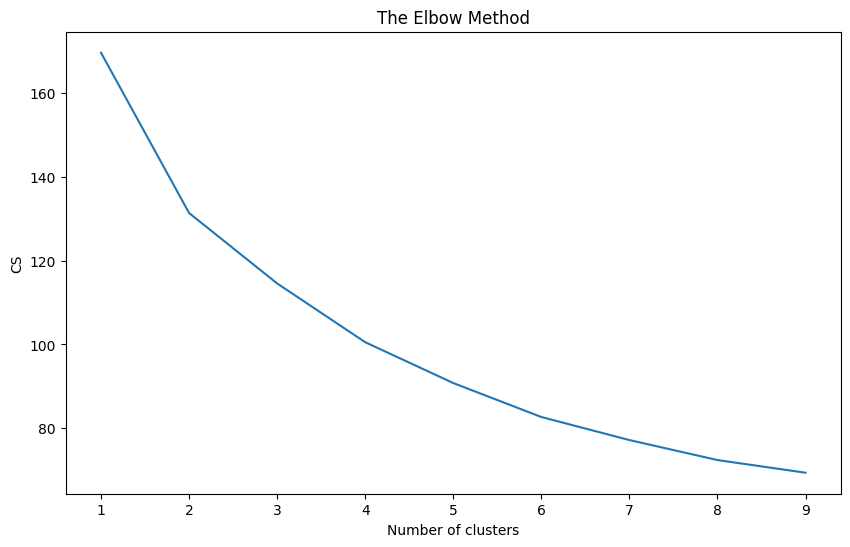

[0 1 2]


/opt/homebrew/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1254: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


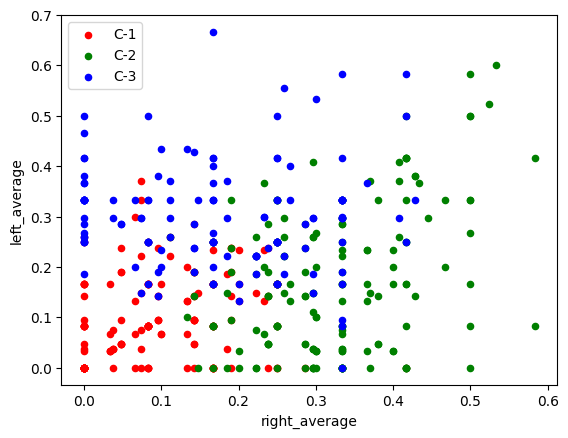

In [9]:
clustering(lingDirectionsAverage)

# SVM Classification for Prediction on Analog Data and Linguistic Data

In [12]:
# Cluster the Data into 3 groups.
def clusteringData(data):
    df = pd.DataFrame.copy(data)
    #OptimalClusterElbowMethod(df)

    # Number of Optimized clusters here would be 3.
    # defining the kmeans function with initialization as k-means++
    kmeans = KMeans(n_clusters=3, init='k-means++')

    # fitting the k means algorithm on scaled data
    kmeans.fit(df)

    pred = kmeans.predict(df)
    frame = pd.DataFrame.copy(df)
    frame['cluster'] = pred
    frame['cluster'].value_counts()

    #Getting unique labels
    label = np.unique(pred)
    print(label)

    return frame


In [71]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# import SVC classifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

def ClassificationData(frame_data):
    df_frame = clusteringData(frame_data)
    #frame_analog = clusteringData(analogDirectionsAverage)

    # Declare feature vector and target variable
    X = df_frame.drop(['cluster'], axis=1)
    y = df_frame['cluster']

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y )

    # check the shape of X_train and X_test
    print("Checking Shape of Data")
    print(X_train.shape)
    print(X_test.shape)

    # instantiate classifier with default hyperparameters
    svc=SVC(kernel='rbf', C=10000.0) 

    # fit classifier to training set
    svc.fit(X_train,y_train)

    # make predictions on test set
    y_pred=svc.predict(X_test)

    # compute and print accuracy score
    print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

    # Print the Confusion Matrix and slice it into four pieces
    cm = confusion_matrix(y_test, y_pred)
    #print('Confusion matrix\n\n', cm)

    plot_confusion_matrix(svc,X_test,y_test)

    #Print the Classification Report
    print ("Classification Report is")
    print(classification_report(y_test, y_pred))
        

# Classifier on Analog Data

[0 1 2]
Checking Shape of Data
(400, 7)
(100, 7)
Model accuracy score: 0.9600
Classification Report is
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.95      0.97      0.96        39
           2       0.97      0.93      0.95        30

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


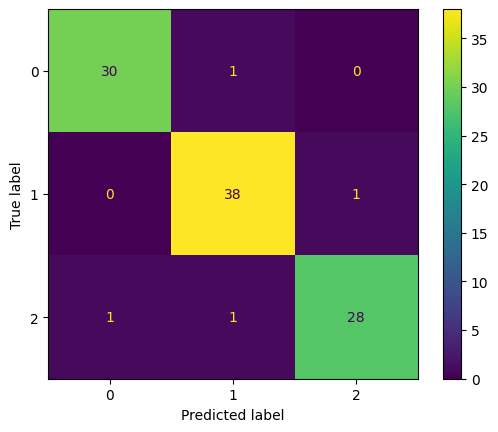

In [76]:
# Classification on Analog Data with 80%-20% split
ClassificationData(analogDirectionsAverage)

# Classifier on Linguistic Data

[0 1 2]
Checking Shape of Data
(400, 7)
(100, 7)
Model accuracy score: 0.9200
Classification Report is
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        35
           1       0.88      0.93      0.90        30
           2       0.94      0.97      0.96        35

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


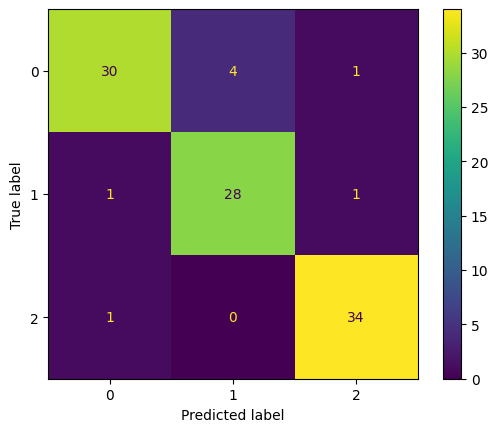

In [88]:
# Classification on Linguistic Data with 80%-20% split
ClassificationData(lingDirectionsAverage)